In [37]:
import sys
from pathlib import Path
import yaml
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchdyn.core import NeuralODE
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.simplefilter("ignore", FutureWarning)

from field_model import *
from model_distances import vectorize_model_params

In [38]:
# load config files for data and pipeline
with open("config.yaml", "r") as f1:
    config = yaml.full_load(f1)

with open("../../data/dataset_params.yaml") as f2:
    data_params = yaml.full_load(f2)

device = torch.device(config["device"])

# dir with trajectories Datasets
traj_dir = Path("trajectories/")
if not traj_dir.exists():
    raise FileNotFoundError("No Datasets created.")

# ode models
models_dir = Path("models/")
if not models_dir.exists():
    raise FileNotFoundError("No models created.")

In [ ]:
num_activities = len(data_params["activity_codes"])

distr_dict = {}
test_dict = {}

In [ ]:
for activity in data_params["activity_codes"]:
    distr_dict[activity] = []

    for state_dict_file in models_dir.glob(f"{activity}*"):
        # load model
        vector_field = eval(config["model_cls"])(config["trajectory_dim"], **config["model_params"])
        ode_model = NeuralODE(vector_field, solver='rk4').to(device)
        ode_model.load_state_dict(torch.load(state_dict_file))

        # save model params
        distr_dict[activity].append(
            vectorize_model_params(ode_model)
        )

    distr_dict[activity] = torch.stack(distr_dict[activity])

    # train/test split
    num_train_params = int(len(distr_dict[activity]) * (1 - config["test_ratio"]))
    test_dict[activity] = distr_dict[activity][num_train_params:]
    distr_dict[activity] = distr_dict[activity][:num_train_params]

In [41]:
distr_dict["jog"].device

device(type='cuda', index=0)

In [42]:
# build distributions
for activity in data_params["activity_codes"]:
    activity_param_mean = distr_dict[activity].mean(dim=0)
    activity_param_cov = torch.cov(distr_dict[activity].T)

    activity_param_cov += torch.diag(1e-7 * torch.ones(activity_param_cov.shape[0])).to(activity_param_cov.device)

    distr_dict[activity] = torch.distributions.MultivariateNormal(
        activity_param_mean,
        activity_param_cov,
        validate_args=True
    )

In [47]:
# classify test models
for activity_ind, activity in enumerate(data_params["activity_codes"]):
    print(f"Classifing {activity}")

    test_params = test_dict[activity]
    probs = {}
    for activity in data_params["activity_codes"]:
        probs[activity] = distr_dict[activity].log_prob(test_params)

    all_probs = torch.stack(list(probs.values()))
    prediction = all_probs.argmax(dim=0)

    print(f"Accuracy = {(prediction == activity_ind).float().mean()}")

Classifing dws


Accuracy = 0.5333333611488342
Classifing ups
Accuracy = 0.20000001788139343
Classifing wlk
Accuracy = 0.40000003576278687
Classifing jog
Accuracy = 0.0
Classifing std
Accuracy = 0.0
Classifing sit
Accuracy = 0.0


При дебаге увидел, что log_prob для всех тестовых примеров очень низкий

[[0.00000000e+00 1.14895720e+08 1.14525344e+08 1.21190912e+08
  1.22428672e+08 1.22297752e+08]
 [1.13405432e+08 0.00000000e+00 1.13048904e+08 1.19882512e+08
  1.20916200e+08 1.20361440e+08]
 [1.13850416e+08 1.13848616e+08 0.00000000e+00 1.21052360e+08
  1.22317088e+08 1.21850592e+08]
 [1.13761160e+08 1.14291192e+08 1.14405760e+08 0.00000000e+00
  1.22536328e+08 1.22320400e+08]
 [1.14093248e+08 1.14092624e+08 1.14860944e+08 1.21573376e+08
  0.00000000e+00 1.22143696e+08]
 [1.13377200e+08 1.13851656e+08 1.13880448e+08 1.20613840e+08
  1.22202376e+08 0.00000000e+00]]


/tmp/ipykernel_138876/2971662575.py:15: RuntimeWarning: divide by zero encountered in log
  np.log(pairwise_kl)


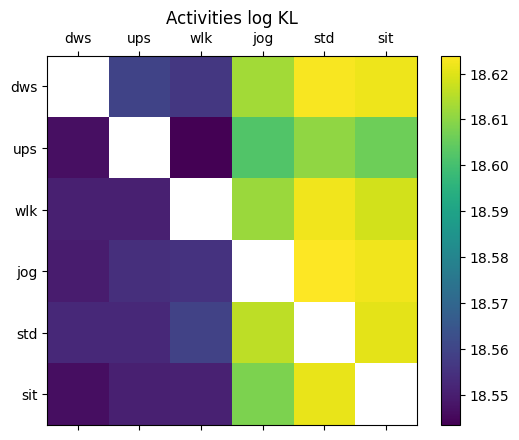

In [44]:
# vizualize kl between distributions
pairwise_kl = np.empty((num_activities, num_activities))

for i, activity_i in enumerate(data_params["activity_codes"]):
    for j, activity_j in enumerate(data_params["activity_codes"]):
        pairwise_kl[i][j] = torch.distributions.kl.kl_divergence(
            distr_dict[activity_i],
            distr_dict[activity_j]
        ).item()

print(pairwise_kl)

fig, ax = plt.subplots()
mat_pic = ax.matshow(
    np.log(pairwise_kl)
)

labels = list(data_params["activity_codes"].keys())
ax.set_xticks(np.arange(len(labels)), labels)
ax.set_yticks(np.arange(len(labels)), labels)
ax.set_title("Activities log KL")
fig.colorbar(mat_pic, ax=ax)
# fig.savefig("pairwise_kl.png")